## Introduction

In this notebook, I will be using LSTM to idedntify peom genre's based on their respective texts. I aim to find an accurate method for differentiating different music genres by their lyrics, while these are not song lyrics, I wanted to use this project as more of a stepping stone rather than a full in depth final model, since it would take significantly longer and require months of work. This dataset is poems and their respective genres and from this data I will build a model that can accuratley detect "decription" from the text to be able to classify it properly.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

These are all the imports I used to pre-process the data and create the LSTM model.

In [48]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gauti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gauti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## EDA

In [49]:
# Read the training and test data
train_data = pd.read_csv('C:/Users/gauti/Desktop/DLFinalProj/data/train_data.csv')
test_data = pd.read_csv('C:/Users/gauti/Desktop/DLFinalProj/data/test_data.csv')

# Display the first few rows of the training data to get a sense of the structure
print("Training Data:")
print(train_data.head())

# Check the structure of the test data
print("\nTest Data:")
print(test_data.head())

Training Data:
   Genre                                               Poem
0  Music                                                NaN
1  Music                In the thick brushthey spend the...
2  Music     Storms are generous.                       ...
3  Music   —After Ana Mendieta Did you carry around the ...
4  Music   for Aja Sherrard at 20The portent may itself ...

Test Data:
   Genre                                               Poem
0  Music  A woman walks by the bench I’m sitting onwith ...
1  Music  Because I am a boy, the untouchability of beau...
2  Music  Because today we did not leave this world,We n...
3  Music  Big Bend has been here, been here. Shouldn’t i...
4  Music  I put shells there, along the lip of the road....


In [50]:
# Display the shape of the dataset
print(f"Training Dataset Shape: {train_data.shape}")
print(f"Test Dataset Shape: {test_data.shape}")


Training Dataset Shape: (841, 2)
Test Dataset Shape: (150, 2)


For EDA I am looking for the genre distribution of the training data, and I am looking at the word distribtion count between each genre. This information can hopefully give me some insight as to what I will see as an output for the model i.e if the data is skewed to a certain genre or a genre has longer words, then how will that affect the outcome of the model and what can I do to improve it.

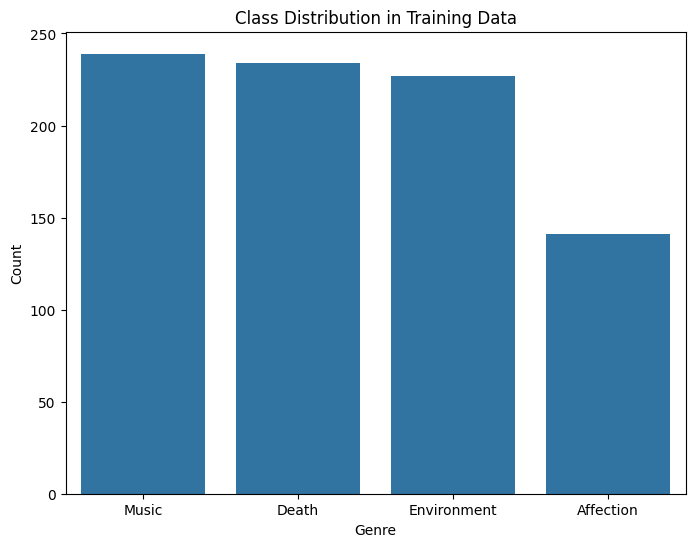

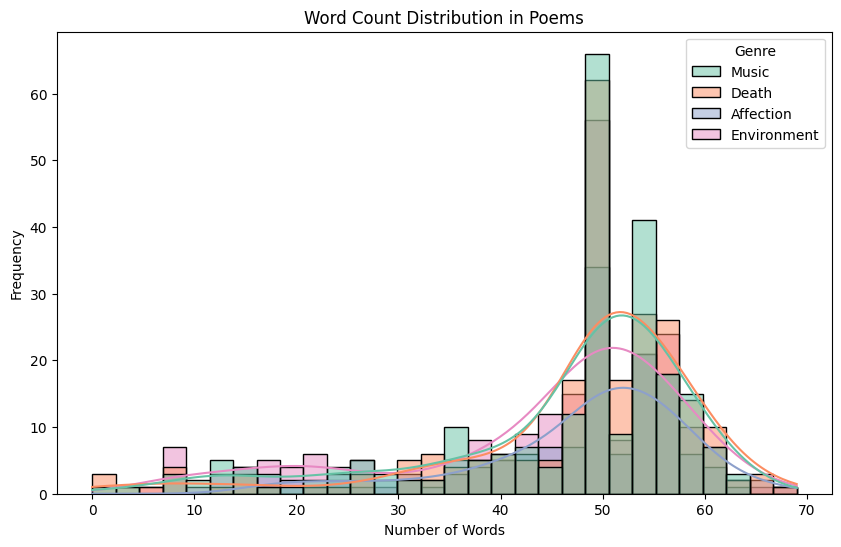

C:\Users\gauti\AppData\Local\Temp\ipykernel_10568\990931852.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=common_words_df, x='Count', y='Word', palette='viridis')


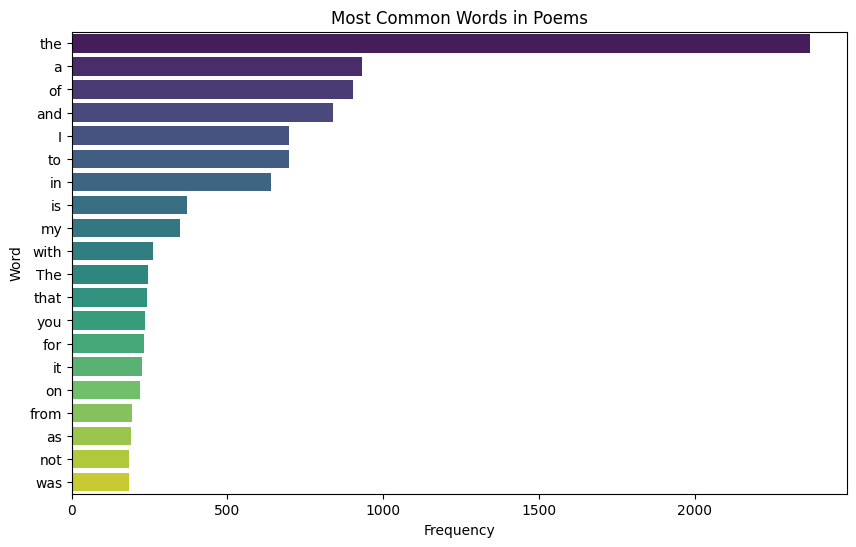

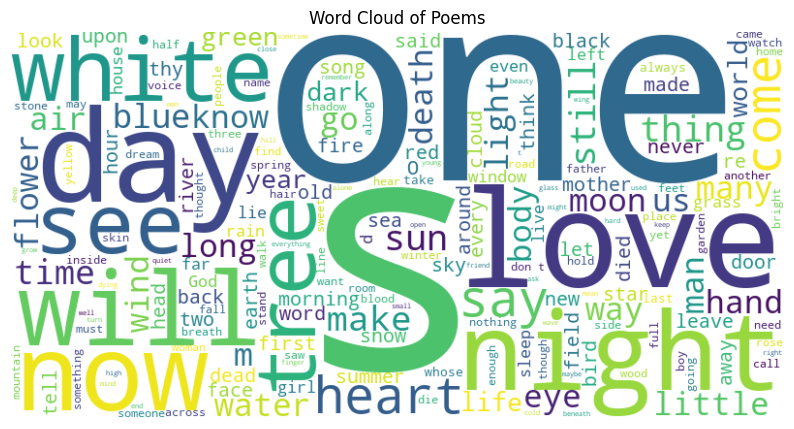

In [51]:
# Checking class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='Genre', order=train_data['Genre'].value_counts().index)
plt.title('Class Distribution in Training Data')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

# Ensure all values in 'Poem' column are strings and handle missing values
train_data['Poem'] = train_data['Poem'].fillna("").astype(str)

# Define the word count function
def count_words(text):
    return len(text.split())

# Apply the function to calculate word count
train_data['Word_Count'] = train_data['Poem'].apply(count_words)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='Word_Count', bins=30, kde=True, hue='Genre', palette='Set2')
plt.title('Word Count Distribution in Poems')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


# Combine all text
all_words = ' '.join(train_data['Poem'])

# Count words
word_counts = Counter(all_words.split())

# Display the most common words as a bar plot
common_words = word_counts.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(data=common_words_df, x='Count', y='Word', palette='viridis')
plt.title('Most Common Words in Poems')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Word Cloud for visualization (Optional)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Poems')
plt.show()


This is for finding any missing values in the data to prepare it for pre-processing, I also printed some standard statistics of the data like how many words there were.

In [52]:
# Check for samples with missing or empty text
missing_text_count = train_data['Poem'].isna().sum()
empty_text_count = (train_data['Poem'] == "").sum()

print(f"Number of samples with missing text: {missing_text_count}")
print(f"Number of samples with empty text: {empty_text_count}")

# Display basic statistics
print("\nBasic Statistics on Word Count:")
print(train_data['Word_Count'].describe())


Number of samples with missing text: 0
Number of samples with empty text: 4

Basic Statistics on Word Count:
count    841.000000
mean      46.375743
std       12.963376
min        0.000000
25%       43.000000
50%       50.000000
75%       55.000000
max       69.000000
Name: Word_Count, dtype: float64


## Pre-Processing

For the pre-processing step I had to use sklearn's `lemmatizer` and the `re` library to pre-process the text into a uniform "shape" so that encoding would be as uniform as possible. For encoding I used sklearn's `LabelEncoder` to encode the genres as {'Affection': 0, 'Death': 1, 'Environment': 2, 'Music': 3}. I then tokenized the text to be processed by the model and padded each text to ensure they are all the same length. While not a lot was done, this step was essential for providing a basic structure for the model to train off of and have room for improvement. 

In [53]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenize and remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

# Apply preprocessing
train_data['Cleaned_Poem'] = train_data['Poem'].apply(preprocess_text)
test_data['Cleaned_Poem'] = test_data['Poem'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
train_data['Encoded_Genre'] = label_encoder.fit_transform(train_data['Genre'])
test_data['Encoded_Genre'] = label_encoder.transform(test_data['Genre'])

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')  # Adjust vocabulary size as needed
tokenizer.fit_on_texts(train_data['Cleaned_Poem'])

train_sequences = tokenizer.texts_to_sequences(train_data['Cleaned_Poem'])
test_sequences = tokenizer.texts_to_sequences(test_data['Cleaned_Poem'])

max_seq_length = 100  # Adjust as necessary
train_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post')

# Output preprocessing results
print("Sample of preprocessed text:", train_data['Cleaned_Poem'].iloc[0])
print("Label encoding mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))



Sample of preprocessed text: 
Label encoding mapping: {'Affection': 0, 'Death': 1, 'Environment': 2, 'Music': 3}


## Modeling

I will be using the sklearn `LSTM` model for this project as it is the one I am most familiar with. The model will only have around 3 layers but each will be comupting with 256 units in each layer. For the parameters most of them are default, but I have changed the following:

vocab_size: 5000 --> 10000

max_seq_length: 50 --> 100

Unit Size Per Layer: 64 --> 256

Output Layer: 4 --> 8

Epochs: 5 --> 12

In [55]:
# Parameters
vocab_size = 10000
embedding_dim = 128
max_seq_length = 100

# Model architecture
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(256)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax')  # 8 output classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

# Training the model
history = model.fit(
    train_padded, train_data['Encoded_Genre'],
    validation_split=0.2,
    epochs=12,
    batch_size=16
)

c:\Users\gauti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.2970 - loss: 1.5537 - val_accuracy: 0.0000e+00 - val_loss: 2.6525
Epoch 2/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3936 - loss: 1.2599 - val_accuracy: 0.0000e+00 - val_loss: 2.2260
Epoch 3/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.7359 - loss: 0.6995 - val_accuracy: 0.0592 - val_loss: 2.4264
Epoch 4/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8740 - loss: 0.3854 - val_accuracy: 0.1065 - val_loss: 3.0926
Epoch 5/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9053 - loss: 0.2970 - val_accuracy: 0.0533 - val_loss: 3.4926
Epoch 6/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9263 - loss: 0.2288 - val_accuracy: 0.0355 - val_loss: 3.9247
Epoch 7/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9313 - loss: 0.1917 - val_accuracy: 0.0414 - val_loss: 4.4391
Epoch 8/12
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9275 - loss: 0.1873 - val_accuracy: 0.

## Testing and Evaluation

In [58]:
test_loss, test_accuracy = model.evaluate(test_padded, test_data['Encoded_Genre'])
print(f"Test Accuracy: {test_accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4225 - loss: 2.2860
Test Accuracy: 0.36


From the test we can see we got abysmal score or 0.36 accuracy. There are tons of ways to improve this model but as a baseline this is about what I would expect.


## Discussion

Some final remarks about the code and project overall, while I think that this is a decent baseline for a model i.e it at least runs and produces an accuracy score that isnt 0, I also think that in order to achieve these higher scores, I would need to implement techniques not only not found in class, but also take months of time to collect different datsets to help train on this dataset. For example, if I found another dataset that was just a dictionary of terms, I am sure I could help the model by having each word be routed to a score based on said dictionary. That being said I enjoyed this project because it allowed me to experiment with the idea of modeling a music genre prediction model to hopefully help applications auto-sort music based on vocal lyrics rather than hoping for correctly pre-defined tags